# 17. Scipy

Scipy implements fundamental algorithms used for scientific computing in Python, including optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics and many other classes of problems.

We will cover a small subset of its functionalities. Refer to https://scipy.org for  the full documentation.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import numpy as np

import scipy


## 17.1 Integration
scipy offers 2 family of functions to compute definite integrals of functions of a single variable $\int_a^b f(x)\, dx$ depending on whether the integrand is a full python function (*i.e.* we can compute $f(x)$ for any $x$) or we know it only at a given fixed points (*i.e.* we have arrays `X` and `Y = f[X]`).

The general method for the former case is `quad` and that of the later is `trapezoid`.

### `scipy.integrate.quad`

* Basic calling scheme: `res, err = scipy.integrate.quad(f,a,b)`. This will return an approximation of the integral and an *estimate* of the accuracy of the approximation.
* One can control the accuracy of integration using the `epsabs` and `epsrel` optional arguments and `quad` will try to return a result satisfying ``abs(I-result) <= max(epsabs, epsrel*abs(I))``, `I` denoting the (unknown) exact value of the integral.
* For functions depending on parameters, one can either use a lambda function or the `args=()` optional argument.
* `scipy.integrate.quad` can compute *some* improper integrals (see the discussion on accuracy later) using `np.inf` as one of the integration bounds.

In [2]:
def f(x):
    return np.sin(x)
print(scipy.integrate.quad(f,0,np.pi))

(2.0, 2.220446049250313e-14)


0.9948012078292787 1.5124008651514634e-14
0.9948012078292787 1.5124008651514634e-14


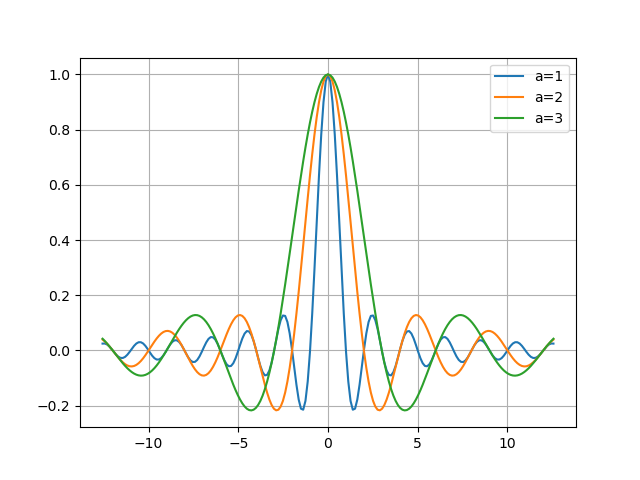

In [3]:
# integrating a function depending on parameters using a lambda function or the args parameter. The later is the recommended way
def g(x,a):
    return np.sinc(x/a)

X = np.linspace(-4*np.pi,4*np.pi,201)
fig, ax = plt.subplots()
for a in (1,2,3):
    ax.plot(X,g(X,a), label = f'a={a}')
ax.legend()
ax.grid()

# for a in (1,2,3):
a = 2
I1, err1 = scipy.integrate.quad(lambda x : g(x,a), 0, np.pi)
print(I1, err1)
I2, err2 = scipy.integrate.quad(g,0,np.pi, args=(a))
print(I2, err2)

In [4]:
# Computing improper integrals
def f1(x):
    return 1/x**2
def f2(x):
    return 1/np.sqrt(x)
print(scipy.integrate.quad(f1,1,np.inf))
print(scipy.integrate.quad(f2,0,1))

(1.0, 1.1102230246251565e-14)
(1.9999999999999984, 5.773159728050814e-15)


In [5]:
# Example of quad rightfully failing to compute a diverging integral
def f3(x):
    return 1/x
print(scipy.integrate.quad(f3,1,np.inf))

(40.996012819169536, 8.156214940493651)


/tmp/ipykernel_1113/292980958.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  print(scipy.integrate.quad(f3,1,np.inf))


/tmp/ipykernel_1113/2792476054.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  print(scipy.integrate.quad(f4,1,np.inf))


(0.673322995986636, 0.00030483050461860284)


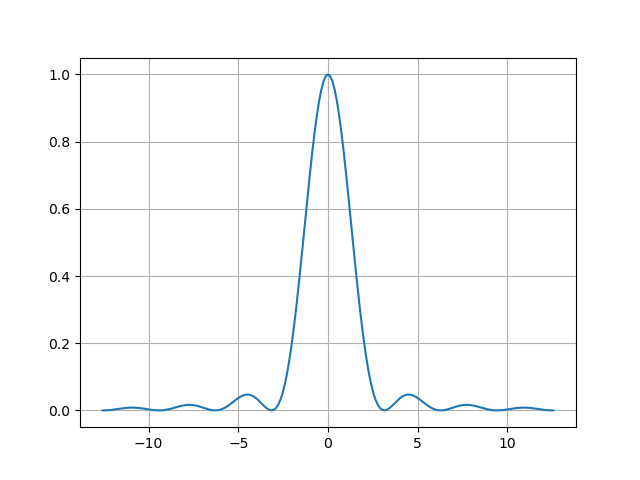

In [6]:
# An example of quad failing to compute a perfectly good (but slow converging) improper integral
def f4(x):
    return np.sin(x)**2/x**2

X = np.linspace(-4*np.pi,4*np.pi,201)
fig, ax = plt.subplots()
for a in (1,):
    # ax.plot(X,1/X**2)
    ax.plot(X,f4(X))
ax.grid()
# notice that 0 <= (sin(x)/x)**2 < 1/x**2 so that by the squeeze theorem, the integral of f4 from 1 to infinity should converge 
print(scipy.integrate.quad(f4,1,np.inf))

`quad` tries really hard to compute definite integrals, but it can fail in some situations. Take for example $f(x) = e^{-x^2}$. We have that 
$$\int_{-\infty}^\infty f(x)\, dx = \sqrt{\pi}.$$
We would therefore expect that when computing $\int_{-b}^b f(x)\, dx$, `quad` would return an increasingly better approximation of $\sqrt{\pi}$ as $b \to \infty$.

In [7]:
def f5(x):
    return np.exp(-x**2)
for b in (1,10,100,1000,10000):
    print(b,scipy.integrate.quad(f5,-b,b), np.sqrt(np.pi))


1 (1.493648265624854, 1.6582826951881447e-14) 1.7724538509055159
10 (1.772453850905516, 3.695852112137264e-13) 1.7724538509055159
100 (1.772453850905516, 1.976815268282025e-10) 1.7724538509055159
1000 (1.7724538509055159, 7.768296244985151e-09) 1.7724538509055159
10000 (1.975190562208035e-203, 0.0) 1.7724538509055159


What happens is that the since $e^{-x^2}$ decays so quickly from $x=0$, the quadrature algorithm used by `quad` does not detect the fact that `f5` is not identically equal to 0.

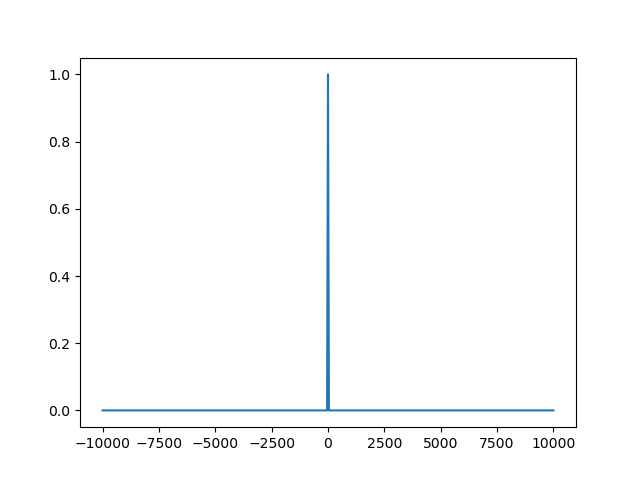

In [8]:
fig, ax = plt.subplots()
b = 10000
X = np.linspace(-b,b,501)
ax.plot(X,np.exp(-X**2))

## `scipy.integrate.trapezoid` and `scipy.integrate.simpson`

In many situations, one may want to estimate the integral of a function that is only known at some given points (this was the case in the Euler's method section of HW2).
`scipy.integrate` can help here too. It implements the trapezoidal rule (see HW2) and Simpson's rule, which relies on the same idea, but where the function is approximated by parabolas instead of segments, using Lagramnge interpolation (see HW2 again!)

* Basic calling sequence: `scipy.integrate.trapezoid(Y, X)` or `scipy.integrate.simpson(Y, X)`
* Note that in order to apply the trapezoidal or Simpson rule, one does not need the location of the sampling points, but only their spacing. For equi-distributed sampling points, one can pass `dx=` instead of `X` as an argument.

In [9]:
n = 5
X = np.linspace(0,np.pi,n)
Y = np.sin(X)
print(scipy.integrate.trapezoid(Y,X))
print(scipy.integrate.simpson(Y,X))

dx = np.pi / (n-1)
print(scipy.integrate.trapezoid(Y,dx = dx))
print(scipy.integrate.simpson(Y,dx = dx))


1.8961188979370398
2.0045597549844207
1.8961188979370398
2.0045597549844207


The ability to pass non-equidistributed points can be used in two ways.
   - When the values of `Y` are not known at equi-distributed points.
   - In order to improve the accuracy of integration, when one knows something about the function to be integrated (recall the issue with $\int_0^b e^{-x^2}\, dx$ for large `b`).

In [10]:
X = np.logspace(-9,0,10)
print(X)

[1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]


In [11]:
n = 5
nint = 51
Ith= np.sqrt(np.pi)/2
for n in range(n):
    print(f'\n Integrating exp(-x^2) on (0,{10**n})')
    Xlog = np.logspace(-9,n,nint)
    # np.logspace returns points whose log is equi-distributed (i.e. with spacing increasing exponentially)
    X = np.linspace(0,10**n,nint)

    print(f'* Simpson with {nint} logspaced sampling points')
    I = scipy.integrate.simpson(f5(Xlog),Xlog)
    print(f'  result: {I:3.5e}, error = {abs(I-Ith):3.5e}')

    print(f'* Simpson with {nint} equidistributed sampling points')
    I = scipy.integrate.simpson(f5(X),X)
    print(f'  result: {I:3.5e}, error = {abs(I-Ith):3.5e}')

    print(f'* scipy.integrate.quad')
    I,err = scipy.integrate.quad(f5,0,10**n)
    print(f'  result: {I:3.5e}, error = {abs(I-Ith):3.5e}')



 Integrating exp(-x^2) on (0,1)
* Simpson with 51 logspaced sampling points
  result: 7.47728e-01, error = 1.38499e-01
* Simpson with 51 equidistributed sampling points
  result: 7.46824e-01, error = 1.39403e-01
* scipy.integrate.quad
  result: 7.46824e-01, error = 1.39403e-01

 Integrating exp(-x^2) on (0,10)
* Simpson with 51 logspaced sampling points
  result: 8.81671e-01, error = 4.55626e-03
* Simpson with 51 equidistributed sampling points
  result: 8.86227e-01, error = 0.00000e+00
* scipy.integrate.quad
  result: 8.86227e-01, error = 1.11022e-16

 Integrating exp(-x^2) on (0,100)
* Simpson with 51 logspaced sampling points
  result: 8.83061e-01, error = 3.16608e-03
* Simpson with 51 equidistributed sampling points
  result: 7.15509e-01, error = 1.70718e-01
* scipy.integrate.quad
  result: 8.86227e-01, error = 1.11022e-16

 Integrating exp(-x^2) on (0,1000)
* Simpson with 51 logspaced sampling points
  result: 8.66117e-01, error = 2.01099e-02
* Simpson with 51 equidistributed sam

### Application: Fourier series

In the early XIXth century, Joseph Fourier proved that "any" periodic function on an interval $(-p,p)$ can be represented by an infinite series of $cos$ and $sin$ of the form:
$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^\infty a_n \cos\left(\tfrac{n\pi}{p}x\right) + b_n \sin \left(\tfrac{n\pi}{p}x\right),
$$
where 
$$ 
a_n = \frac{1}{p}\int_{-p}^p f(x) \cos\left(\tfrac{n\pi}{p}x\right)\, dx
$$
and 
$$ 
b_n = \frac{2}{p}\int_{-p}^p f(x) \sin\left(\tfrac{n\pi}{p}x\right)\, dx
$$
Let's illustrate this when $f$ is a periodic function on $[-1,1]$ such that 
$$
f(x) = \begin{cases}
1+x & \text{ if } x<0\\
1-x & \text{ if } x\ge0.
\end{cases}
$$

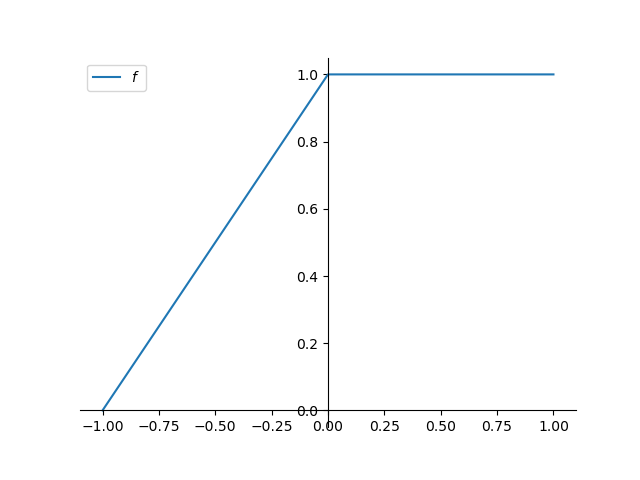

In [12]:
def ff(x):
    if x <0:
        return 1+x
    else:
        return 1

f = np.vectorize(ff)

fig, ax = plt.subplots()
X = np.linspace(-1,1,101)
ax.plot(X,f(X), label = '$f$')
ax.spines[['left', 'bottom']].set_position('zero')
ax.spines[['top', 'right']].set_visible(False)
ax.legend()

In [21]:
def FourierCoefs(f, p, N):
    ''' 
    Returns the N first coefficients of the Fourier expansion of f on (-p,p)
    '''
    a = np.empty(N)
    b = np.empty(N)
    for n in range(N):
        # f(x) * cos(n.pi x/p)
        a[n] = scipy.integrate.quad(lambda x : np.cos(n * np.pi * x / p) * f(x), -p,p)[0] / p
        b[n] = scipy.integrate.quad(lambda x : np.sin(n * np.pi * x / p) * f(x), -p,p)[0] / p
        # note that b[0] = 0
    return a,b
def FourierEval(X, a, b, p, N):
    '''
    Evaluates the sum of the Fourier series on (-p,p) with coefficients a and b at x
    '''
    f = np.ones(len(X)) * a[0]/2
    if N > len(a):
        raise IndexError(f"Requested {N} coefficients but got only {len(a)}")
    for n in range(1,N):
        f += a[n] * np.cos(n*np.pi*X/p) + b[n] * np.sin(n*np.pi*X/p)
    return f


def plot(a,b,p,N,X,f):
    ax.cla()
    ax.plot(X,f(X), label = '$f$')
    ax.plot(X,FourierEval(X,a,b,p,N),label = f'$F_{{{N}}}$')
    ax.spines[['left', 'bottom']].set_position('zero')
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend()

N = 10
p = 1
a,b = FourierCoefs(f,p,N)
print('a: ', a)
print('b: ', b)


# FourierEval(X,a,b,p,1)

a:  [ 1.50000000e+00  2.02642367e-01  3.46944695e-17  2.25158186e-02
  2.42861287e-17  8.10569469e-03 -1.37043155e-16  4.13555852e-03
 -2.79290480e-16  2.50175762e-03]
b:  [ 0.          0.31830989 -0.15915494  0.1061033  -0.07957747  0.06366198
 -0.05305165  0.04547284 -0.03978874  0.03536777]


interactive(children=(IntSlider(value=25, description='N', max=50, min=1), Output()), _dom_classes=('widget-in…

<function __main__.<lambda>(N)>

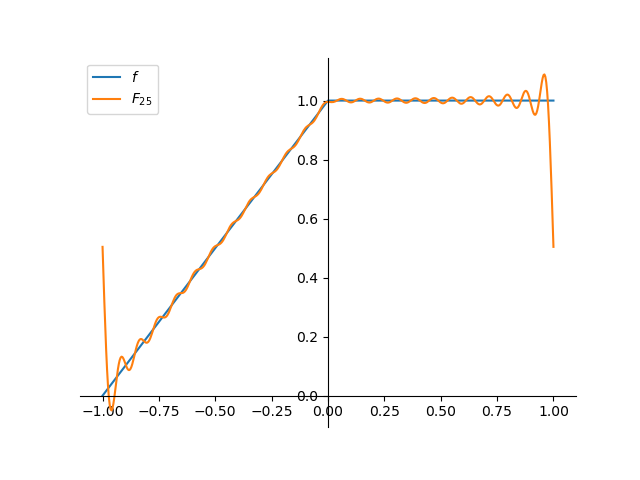

In [29]:
from ipywidgets import interact
p = 1
Nmax = 50
X = np.linspace(-p,p,501)

a,b = FourierCoefs(f,p,Nmax)

fig, ax = plt.subplots()
ax.plot(X,f(X), label = '$f$')

def pplot(N):
    plot(a,b,p,N)
interact(lambda N: plot(a,b,p,N,X,f), N = (1,Nmax,1))
# interact(pplot, N = (1,Nmax,1))
